In [1]:
# Copyright (c) 2025, InfinityQ Technology Inc.

# Prompt the user and wait for an answer before installing dependencies.
# Note: Usage of a virtual Python environment is recommended.
if input("Install Python dependencies? [y/n]").lower() == "y":
    print("Installing dependencies (this can take a few minutes)...")
    !pip install -r "requirements.txt" --upgrade
else:
    print("Skipping dependency installation.")

import numpy as np
import logging
from model_generation import *
from titanq import Model, Vtype, Target
import warnings

# Filter out FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.getLogger('botocore').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)

Skipping dependency installation.


## Setting Credentials
The user should configure their TitanQ API key and AWS access keys here.

In [2]:
# Enter your API key here
# Obtain your API key by contacting --> support@infinityq.tech
# Example: TITANQ_DEV_API_KEY = "00000000-0000-0000-0000-000000000000"
TITANQ_DEV_API_KEY = input("Please enter your API key (e.g. 00000000-0000-0000-0000-000000000000):")

## Setting Up The Problem
There are two examples for your ease of use in the instances folder, currencies_6 and currencies_25.

For those who want to load in a full historical currency pair set, set your variable full_dataset to be True and data from the month day and year will be downloaded and used for the example.

We then load the exchange rate data into our dataframe, which we call our exchange rate matrix. Missing data is replaced with 0 to avoid invalid currency exchanges.

- If you opt for one of the 2 instances, specify the instance below (currencies_6 or currencies_25)

In [ ]:
# If loading an instance, valid instances are "currencies_6" and "currencies_25"
instance = "currencies_6"

# If loading a full day of data, set this to true
# Note: This option requires obtaining and specifying AWS access and secret access keys from polygon.io (https://polygon.io/)
full_dataset = False
aws_access_key_id = None
aws_secret_access_key = None

# For full dataset input in the format below
# Anywhere between Jan 2010 - Present
year = '2025'
month = '01'
day = '02'

if full_dataset:
    # Create the polygon AWS session
    session = start_polygon_session(aws_access_key_id, aws_secret_access_key)

    # Download data from polygon
    generate_data_polygon(session, year, month, day)

    # Load currency data into dataframe
    currencies, df = load_day_data(year, month, day)
else:
    # Load a specific instance data
    currencies, df = load_instance_data(instance)

# Number of nodes in graph
size = len(currencies)
print(f"Number of currencies: {size}")

exch_rate_matrix = df.to_numpy().astype(np.float32)

## Create Bias Vector
To maximize arbitrage opportunity, we want to maximize the product of the exchange rates we use. We take the log of the exchange rates to convert the formulation into a summation. We also multiply each term of the objective function by -1 to pose it as a minimization problem for TitanQ. ```x``` is a vector of the length of the number of edges, and each entry is a binary variable encoding whether the edge will be used in our final solution.

We also want to prevent solutions that use non-existent edges, so we only keep track of edges that exist in the graph. This also helps preserve space and reduce the solve time, especially for graphs with a lot of nodes and not a lot of edges. Thus we shorten our exchange rate matrix and bias vector to only include non-zero values, and keep track of all of our edge names.

In [4]:
# List existing edges for TitanQ formulation
edges = [(i, j) for i in range(size) for j in range(size) if exch_rate_matrix[i,j] > 0]
num_edges = len(edges)

# Exchange rates for existing edges only
exch_rate_values = exch_rate_matrix[tuple(zip(*edges))]

# Bias vector for objective
bias = np.where(exch_rate_values > 0, -np.log(exch_rate_values), 1.).astype(np.float32)

edge_names = [currencies[i]+"/"+currencies[j] for (i,j) in edges]

## Input Problem into TitanQ SDK
The objective and constraint expressions are set here and TitanQ is called to solve the model.

The flow constraint restricts the sum of all purchases of a currency to be equal to the sum of all sales of a currency.
We also forbid exchanging through a currency more than once. This is our number of exchanges constraint.

In [5]:
#############
# TitanQ Model
#############
model = Model(
    api_key=TITANQ_DEV_API_KEY
)

# Defining variables, objective, and constraints in TitanQ model
x = model.add_variable_vector('x', num_edges, Vtype.BINARY)
model.set_objective_expression(np.dot(bias, x), Target.MINIMIZE)

# Cycle constraints
for i in range(len(currencies)):
    # List of all edge indices (i, j)
    incoming = [index for index, (a, b) in enumerate(edges) if a == i]

    # List of all edge indices (j, i)
    outgoing = [index for index, (b, a) in enumerate(edges) if a == i]

    if incoming == [] and outgoing == []:
        continue
    # Flow constraint
    model.add_constraint_from_expression(sum(x[j] for j in incoming) - sum(x[j] for j in outgoing) == 0)

    # Number of exchanges constraint
    if incoming == []:
        model.add_constraint_from_expression(sum(x[j] for j in outgoing) <= 1)
    else:
        model.add_constraint_from_expression(sum(x[j] for j in incoming) <= 1)

# TitanQ Solver hyperparameters
num_chains = 8
num_engines = 1
Tmin = 0.0001
timeout_in_secs = 2

if full_dataset:
    # Hyperparameters for full dataset
    Tmax = 550
    penalty_scaling = 45

else:
    # Hyperparameters for currencies_6 or currencies_25
    Tmax = 122
    penalty_scaling = 15

response = solve_model(model, num_chains, num_engines, Tmin, Tmax, timeout_in_secs, penalty_scaling)

╭───────────────────── v0.36.0 ─────────────────────╮
│      _________________              _______       │
│      ___  __/__(_)_  /______ _________  __ \      │
│      __  /  __  /_  __/  __ `/_  __ \  / / /      │
│      _  /   _  / / /_ / /_/ /_  / / / /_/ /       │
│      /_/    /_/  \__/ \__,_/ /_/ /_/\___\_\       │
│                                                   │
│                                                   │
╰───────────────────────────────────────────────────╯
[17:01:11] 🔧 Preparing data for TitanQ...                                      
[17:01:11] 📤 Starting data upload...                                           
[17:01:12] 🕐 Upload completed!                                                 
[17:01:12] 🚀 Sending request to the server...                                  
[17:01:14] ✅ Optimization completed!                                           


## Outputting Results
The list of solutions for each engine can be accessed from the variable label defined before (in this case: ```x```). For each engine we print:
- The solution vector ```x```
- All profitable cycles
- The profit gained from each cycle
- The Ising energy of the solution (objective value)

Then we print the *best* valid cycle. This gives a series of currency exchanges for optimal arbitrage gain.

#### Example:
Best cycle ('HUX/USD', 'USD/RUB', 'RUB/HUX'): 0.017367341154281624

profit: 1.7367341154281624 %

energy: -0.004294343292713165

In [6]:
best_weight, best_cycle = analyze_results(response, edge_names, currencies, exch_rate_matrix)

-------- ALL ENGINE RESULTS --------

--- Engine 1 ---
Cycle 1: ('EUR/USD', 'USD/GBP', 'GBP/EUR')
Product of Exchange Rates:  1.0001129601401646
Profit: 0.011296014016459743 %

Energy: -0.000112973153591156

-------- BEST VALID SOLUTION --------
--- Engine 1 ---
Best Cycle:  ('EUR/USD', 'USD/GBP', 'GBP/EUR')
Product of Exchange Rates:  1.0001129601401646
Best Profit:  0.011296014016459743 %
Energy: -0.000112973153591156


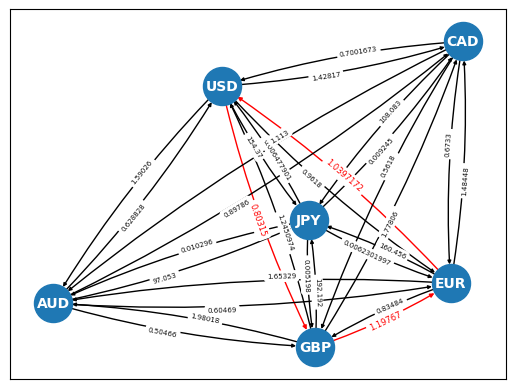

In [7]:
# Plot on a graph for currencies_6 example
if not full_dataset and instance == 'currencies_6':
    G = nx.MultiDiGraph()
    plot_graph(G, best_cycle, edge_names, exch_rate_values)

**If you loaded full dataset:**

For simplicity purposes, the above example only generated arbitrage opportunities for the *last* time step in the day.

Optionally, you can generate minute-by-minute profit data for the entire day and plot the results on a graph for visualization purposes (which takes ~10 minutes):

In [8]:
import matplotlib.pyplot as plt
if full_dataset:
    bps = 0.08
    times, profits = generate_minute_profit(TITANQ_DEV_API_KEY, "10T", bps)

    hourly = pd.date_range(start=times[0], end=times[-1], freq='2H')
    plt.figure()
    plt.plot(times, profits, linestyle='-')
    plt.xticks(hourly, labels=[tick.strftime('%H') for tick in hourly])
    plt.xlabel("Time (h)")
    plt.ylabel("Profit %")
    plt.title(f"Minute-by-Minute Arbitrage Opportunities Found by TitanQ on 2025/01/02 with {bps} bps")
    plt.show()